In [1]:
import itertools
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller


warnings.filterwarnings("ignore")


def get_data(cbsa: str) -> pd.DataFrame:

    cbsa_normalized = cbsa.lower()

    query = f"""
    SELECT name, date, total 
    FROM building_permits 
    WHERE lower(name) LIKE '%{cbsa_normalized}%'
    """

    with sqlite3.connect("../db/realestate.db") as conn:
        df = pd.read_sql_query(query, conn)

    if df.empty:
        print(f"No data found for CBSA: {cbsa}")
        return df

    print(f"Data retrieved for CBSA(s): {df['name'].unique()}")

    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)

    return df


def resample_data(df: pd.DataFrame, how: str = "sum", rule: str = "Q") -> pd.DataFrame:
    diff_data = df["total"].resample(rule=rule).mean().ffill()
    return diff_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Data retrieved for CBSA(s): ['Austin-Round Rock, TX' 'Austin-Round Rock-San Marcos, TX'
 'Austin-Round Rock-Georgetown, TX']


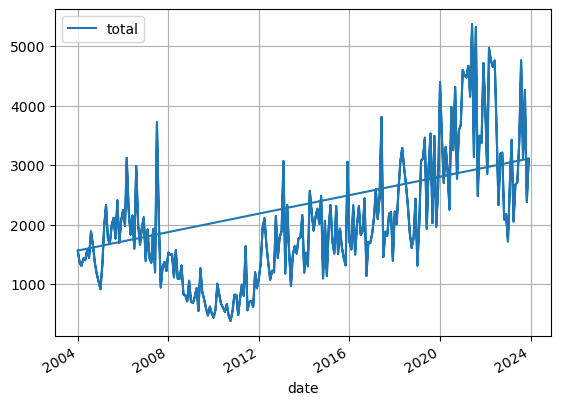

In [2]:
data = get_data("austin")
data.plot(grid=True)
plt.show()

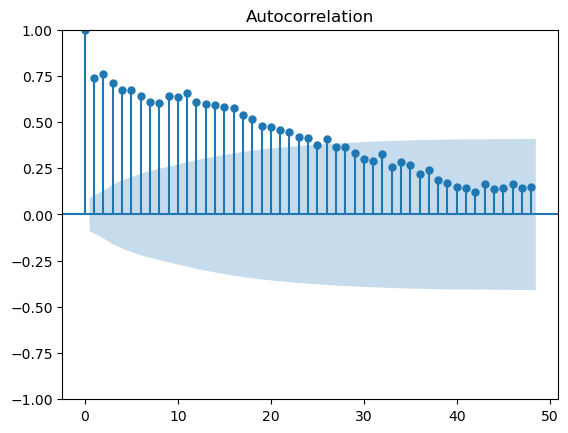

In [3]:
# resampled_data = resample_data(data)
# resampled_data.plot(grid=True)
# plot_acf(resampled_data, alpha=0.05, lags=4)

plot_acf(data["total"], alpha=0.05, lags=48)
plt.show()

In [4]:
# Run the ADF test on the total building permits series and print out the results
# results = adfuller(resampled_data)
results = adfuller(data["total"])
print("ADF Statistic: %f" % results[0])
print("p-value: %f" % results[1])
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

p_val = results[1]

print("The p-value of the building permits data is: " + str(p_val))

stationary = None
if p_val < 0.05:
    stationary = True
    print(
        "We can reject the null hypothesis that the building permits series has a unit root, with 95% confidence. The series is likely stationary."
    )
else:
    stationary = False
    print(
        "We cannot reject the null hypothesis that the building permits series has a unit root, with 95% confidence. The series may be non-stationary."
    )

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


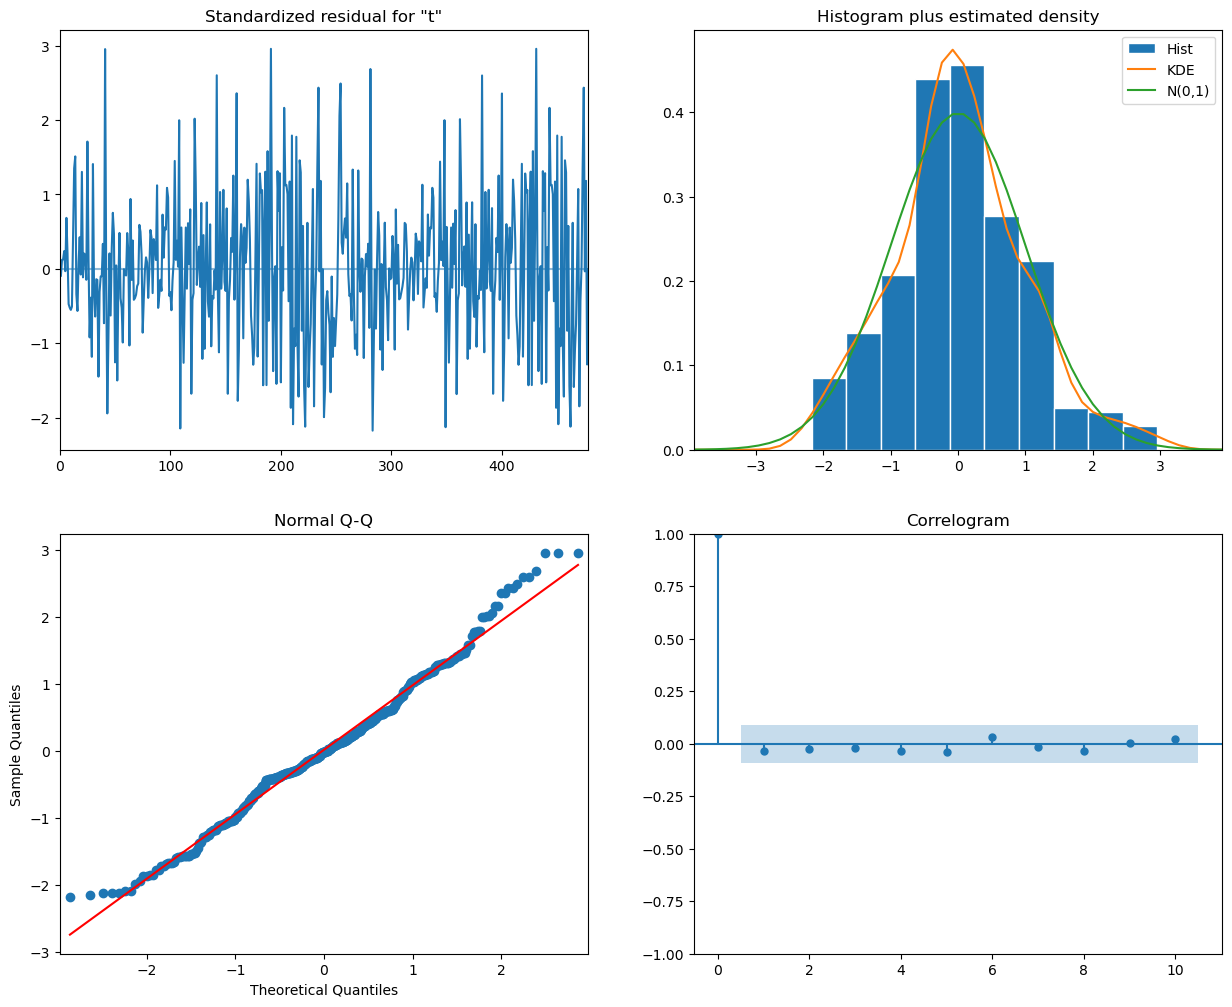

In [5]:
# Define the range for p and q parameters
p = range(0, 10)
d = [0] if stationary else range(0,3)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(data["total"], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except Exception as e:
        continue

print(f"Best ARIMA{best_order} model AIC: {best_aic}")

best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

2023-12-02 00:00:00.000000000    2769.947695
2024-01-03 17:27:16.363636363    2663.773869
2024-02-05 10:54:32.727272727    2342.864601
2024-03-09 04:21:49.090909090    2562.759799
2024-04-10 21:49:05.454545454    2688.000652
2024-05-13 15:16:21.818181818    3093.602636
2024-06-15 08:43:38.181818180    3543.726678
2024-07-18 02:10:54.545454544    3193.528444
2024-08-19 19:38:10.909090908    3643.775649
2024-09-21 13:05:27.272727272    3334.249415
2024-10-24 06:32:43.636363636    3613.789928
2024-11-26 00:00:00.000000000    3683.454690
Name: predicted_mean, dtype: float64


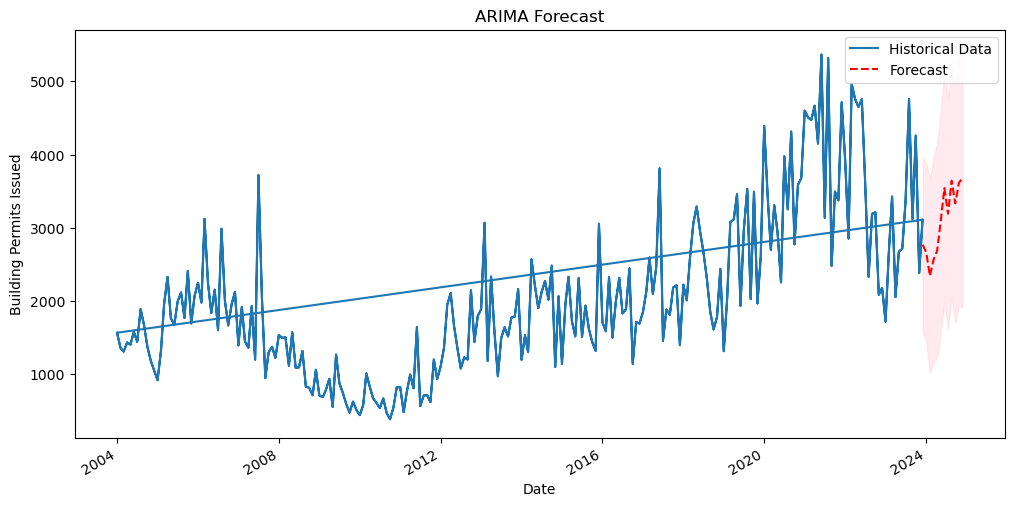

In [6]:
# ensure data's index is a DateTimeIndex and properly formatted
data.index = pd.to_datetime(data.index)

steps_ahead = 12
forecast = best_model.get_forecast(steps=steps_ahead)

forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Align forecast index with the data timeline
forecast_start = data.index[-1] + pd.Timedelta(days=1)
# Approximate each period as 30 days
forecast_end = forecast_start + pd.Timedelta(days=steps_ahead * 30)
forecast_index = pd.date_range(
    start=forecast_start, end=forecast_end, periods=steps_ahead
)
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

print(forecast_values)

# Plot historical data
plt.figure(figsize=(12, 6))
data["total"].plot(label="Historical Data")

# Plot forecasted values
forecast_values.plot(style="r--", label="Forecast")

# Plot the confidence intervals
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color="pink",
    alpha=0.3,
)

plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Building Permits Issued")
plt.legend()
plt.show()